In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()
ttrain=train.drop('Attrition',axis=1)
all_data = pd.concat((ttrain.loc[:,'Age':],
                      test.loc[:,'Age':]))
all_data = pd.get_dummies(all_data)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.Attrition
all_data.head()

,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,30,2,3,571,3,3,4,2564,0,14,...,0,0,0,0,0,0,0,1,1,0
1,36,12,4,1614,3,3,3,4663,9,12,...,1,0,0,0,0,0,1,0,0,1
2,55,2,1,842,3,3,4,5160,4,16,...,0,0,0,1,0,0,0,1,1,0
3,39,24,1,2014,1,3,4,4108,7,13,...,0,0,1,0,0,0,0,1,1,0
4,37,3,3,689,3,3,3,9434,1,15,...,1,0,0,0,0,0,1,0,1,0


In [8]:
trial=all_data.drop(['OverTime_Yes','MaritalStatus_Single','JobRole_Sales Representative','Gender_Male','BusinessTravel_Travel_Rarely','EducationField_Medical','Department_Human Resources'],axis=1)
X_train2 = trial[:train.shape[0]]
X_test2 = trial[train.shape[0]:]
y = train.Attrition


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

In [10]:
from sklearn.metrics import mean_squared_error
model=RandomForestClassifier()
model.fit(rescaledX , y)

# transform the validation dataset
rescaled_X_test = scaler.transform(X_test)


In [11]:
# predictions = model.predict(rescaled_X_test)
# predictions

In [13]:
predictions = model.predict_proba(rescaled_X_test)[:,1]


In [14]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

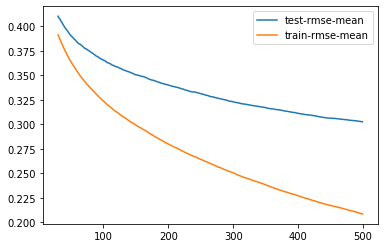

In [15]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [16]:
model_xgb = xgb.XGBClassifier(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv  n_estimators=360, max_depth=2, learning_rate=0.1
model_xgb.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=360, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
xgb_preds = np.expm1(model_xgb.predict_proba(X_test)[:,1])
preds = 0.7*predictions + 0.3*xgb_preds


In [81]:
solution = pd.DataFrame({"id":test.Id, "Attrition":preds})
solution.to_csv("randomxgbproba2.csv", index = False)